In [1]:
%pip install torch torchvision transformers diffusers datasets accelerate


In [2]:
from transformers import AutoImageProcessor, Dinov2ForImageClassification
from diffusers import DiffusionPipeline
import torch
from diffusers import DPMSolverMultistepScheduler
import requests
import torchvision.transforms as transforms
from PIL import Image
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt

C:\Users\tomma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
discriminator_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-small")
discriminator_model = Dinov2ForImageClassification.from_pretrained("facebook/dinov2-small")

discriminator_model.classifier = torch.nn.Linear(768, 1)

teacher_model = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
teacher_model.scheduler = DPMSolverMultistepScheduler.from_config(teacher_model.scheduler.config)

student_model = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
student_model.scheduler = DPMSolverMultistepScheduler.from_config(student_model.scheduler.config)

Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-small and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Loading pipeline components...:  29%|██▊       | 2/7 [00:00<00:00, 13.38it/s]`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
Loading pipeline components...:  29%|██▊       | 2/7 [00:00<00:01,  2.61it/s]`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overr

In [7]:
# Move models to the chosen device

# discriminator_model = discriminator_model.to(device)
student_model = student_model.to(device)
teacher_model = teacher_model.to(device)

In [9]:
class HingeLoss(torch.nn.Module):
    def __init__(self):
        super(HingeLoss, self).__init__()

    def forward(self, output, target):
        return (torch.tensor(target-output))


# Hinge loss for adversarial loss and L2 loss for distillation
# adversarial_loss_function = HingeLoss()
adversarial_loss_function = torch.nn.BCELoss()
distillation_loss_function = torch.nn.MSELoss()

# Set up the optimizer for the student model
student_optimizer = torch.optim.Adam(student_model.unet.parameters(), lr=0.0001)

# Assuming you have a discriminator model defined
#discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
discriminator_model_optimizer = torch.optim.Adam(discriminator_model.parameters(), lr=0.0001)

In [10]:
# load the train dataset from folder dataset/captions_train2017.json
dataset = load_dataset('json', data_files='dataset/train.json')

train_dataset = dataset["train"]

print(train_dataset)

print(train_dataset[0])

Dataset({
    features: ['caption', 'image'],
    num_rows: 295876
})
{'caption': 'A bicycle replica with a clock as the front wheel.', 'image': 'http://images.cocodataset.org/train2017/000000203564.jpg'}


In [11]:
# Function to convert an image from a URL to a PyTorch Tensor
def url_to_tensor(url):

    img = Image.open(requests.get(url, stream=True).raw)

    # Define a transform to convert the image to tensor
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize the image
        transforms.ToTensor()           # Convert the image to a PyTorch Tensor
    ])

    # Apply the transform to the image
    img_tensor = transform(img)

    return img_tensor

# Get the first image in the training dataset
img_tensor = url_to_tensor(train_dataset[0]['image'])

# Print the shape of the image tensor
print(img_tensor.shape)

torch.Size([3, 256, 256])


In [ ]:
def show_tensor_image(pic):

    # Convert the tensor to a PIL Image
    if (isinstance(pic, torch.Tensor)):
        pil_image = transforms.ToPILImage()(pic)

    else:
        pil_image = pic

    # Display the image
    plt.imshow(pil_image)
    plt.axis('off')  # Turn off axis numbers
    plt.show()

def forward_noise(image, a, s, num_diffusion_steps):

    if (not isinstance(image, torch.Tensor)):
        transform = transforms.ToTensor()
        image = transform(image)

    for i in range(num_diffusion_steps):
        noise = np.random.normal(size=image.shape)  # noise mask
        image = image * a + noise * s

    return image

base_image: A bicycle replica with a clock as the front wheel.


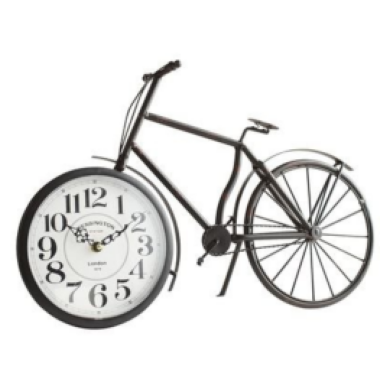

Noise image


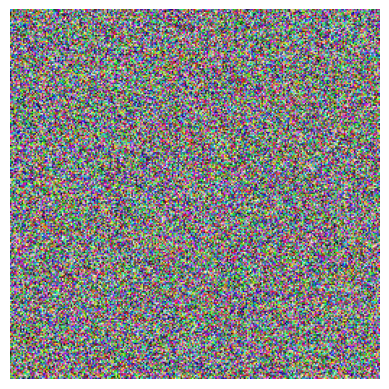

Student image


100%|██████████| 4/4 [00:02<00:00,  1.82it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


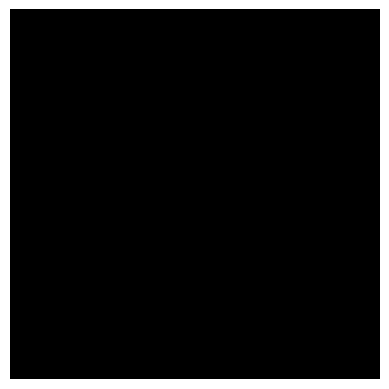

New noised image


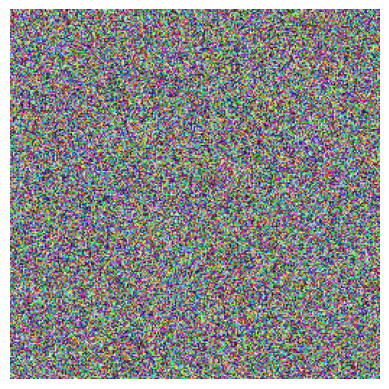

Teacher image


100%|██████████| 30/30 [00:20<00:00,  1.50it/s]


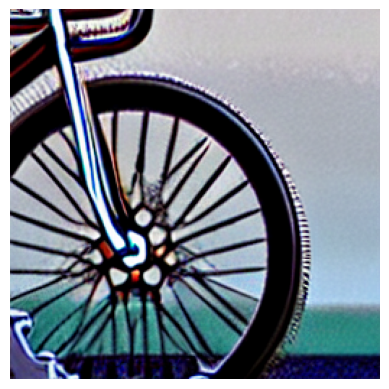

base_image: A room with blue walls and a white sink and door.


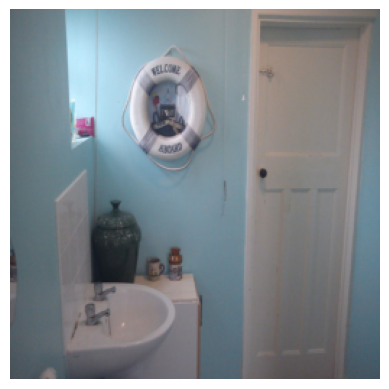

Noise image


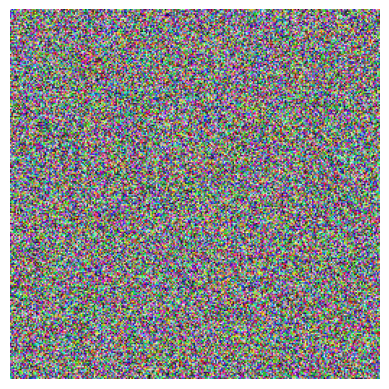

Student image


100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


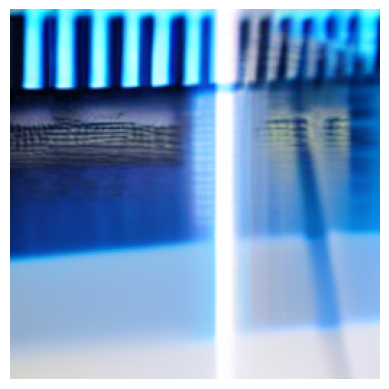

New noised image


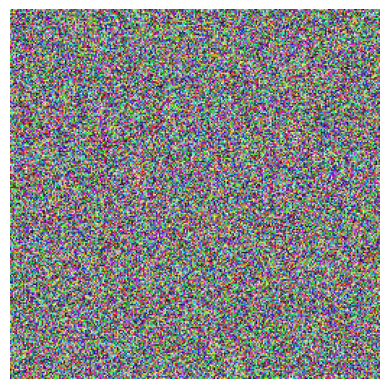

Teacher image


 57%|█████▋    | 17/30 [00:11<00:08,  1.53it/s]


KeyboardInterrupt: 

In [17]:
for epoch in range(100):
    for batch in train_dataset:

        image = url_to_tensor(batch["image"])
        caption = batch["caption"]

        valid = torch.ones(image.size(0), 1)
        fake = torch.zeros(image.size(0), 1)
        real_image = image

        print(f"base_image: {caption}")
        show_tensor_image(real_image)

        # Perform forward diffusion with the specified number of steps
        print("Noise image")
        diffused_image = forward_noise(image, a = 0.5, s = 0.5, num_diffusion_steps = 50)
        show_tensor_image(diffused_image)

        #Compute student image
        print("Student image")
        student_image = student_model(caption, image = diffused_image, height=256, width=256, num_inference_steps=4).images[0]
        show_tensor_image(student_image)

        #Perform again forward diffusion with the specified number of steps
        print("New noised image")
        new_diffused_image = forward_noise(student_image, a = 0.5, s = 0.5, num_diffusion_steps = 50)
        show_tensor_image(new_diffused_image)

        #Compute teacher image
        print("Teacher image")
        teacher_image = teacher_model(caption, image = new_diffused_image, height=256, width=256, num_inference_steps=30).images[0]
        show_tensor_image(teacher_image)


        



